In [3]:
import os
os.environ["ESMFMKFILE"] = "/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/esmf.mk"
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy
import numpy as np
import pandas as pd
import xarray as xr
import scipy
from scipy import special
from scipy.stats import norm
from scipy.stats import ks_2samp as ks_2samp
import sys 
import xesmf as xe 
import cartopy.feature as cfeature
import cftime
from netCDF4 import Dataset
from netCDF4 import num2date

In [33]:
# Common parameters to the three resolutions
W=5

if W > 3: 
    W_EMO5 = 4
else : 
    W_EMO5 = W 

    
D = 'ccs'

do_plot = D 

root_dir = '/data/cmcc/ls21622/gcm_driven_experiment_from_nird/'
fig_dir = f'{root_dir}/scripts/python_2/plotter/hws/figures' 


boundaries = np.array([1,16.9,40.5,50]) ; min_lon,max_lon,min_lat,max_lat = boundaries

to_tit = ['HWs mean Tmax', 'HWs max Tmax', 'HWs persistence', 'HWMId',
          'HWs mean HFLS','HW evap. deficit','HWs count']

clabs=["°C","°C","days","HWMId","W/m^2","Evap. deficit","N."]

variables=['HW_mean_tmax','HW_max_tmax','HW_persistence','HW_HWMI',
           'HW_mean_hfls','HW_hfls_deficit','HW_number']

var = variables[W]

variables_to_tit = ['HWs mean Tmax', 'HWs max Tmax', 'HWs persistence', 'HWMId',
                    'HW mean hfls','HW evap. deficit','HWs number'] 

var_to_tit = variables_to_tit[W]

execute_array_his = ['ds_his.HW_mean_tmax','ds_his.HW_max_tmax','ds_his.HW_persistence',
                     'ds_his.HW_HWMI','ds_his.HW_mean_hfls','ds_his.HW_hfls_deficit',
                     'ds_his.HW_number']

execute_array_rcp85 = ['ds_rcp85.HW_mean_tmax','ds_rcp85.HW_max_tmax','ds_rcp85.HW_persistence',
                       'ds_rcp85.HW_HWMI','ds_rcp85.HW_mean_hfls','ds_rcp85.HW_hfls_deficit',
                       'ds_rcp85.HW_number']

cmin=         [ 1,   1,   -2,  -5,  -60, -5,  -1  ]
cmax=         [ 10,  10,  2,    5,   60,  5,   1  ]
cint=         [ 10,  10,  9,   11,   21,  11,  11 ]       
        
cmin_spread = [.5,  .5,   0,   0,   10,   0,   0  ]
cmax_spread = [ 3.5, 4,   3,   5,   30,   5,   2  ]
cint_spread = [.5,  .5,   .5,  .5,   2,  .5,  .5  ]

levels_ccs  = np.linspace(cmin[W],cmax[W],cint[W])
levels_std  = np.arange(cmin_spread[W],cmax_spread[W],cint_spread[W])
        
        
colormap_his = ['turbo', 'turbo',  'turbo', 'turbo', 'turbo_r', 'turbo', 'turbo']
colormap_bias = 'coolwarm'
colormap_ccs = ['YlOrRd','YlOrRd', 'YlOrRd','YlOrRd','PuOr_r', 'PuOr_r', 'YlOrRd']
colormap_ccs = ['YlOrRd','YlOrRd', 'Spectral_r','Spectral_r','Spectral', 'Spectral_r', 'Spectral_r']
colormap_std = 'viridis'

## RCMs

In [34]:
res='RCM'

models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ',
                         'HCLIM','KNMI','CNRM','ICTP','UKMO']
models = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM',
          'ICTP','KIT','KNMI','UKMO']

dir_home_his    = f'{root_dir}/scripts/python_2/hws/OUTPUTS/historical/nonCP'
dir_home_rcp85   = f'{root_dir}/scripts/python_2/hws/OUTPUTS/rcp85/nonCP/derived_on_rcp85_clima'

# Load datasets
ds_his = []
ds_his = xr.open_mfdataset(f'{dir_home_his}/*.nc',combine='nested',concat_dim='model')
ds_his.load()
ds_his = ds_his.sel(model=models_ranked_to_plot)
ds_his['lat'] = ds_his.lat.mean(dim='model')
ds_his['lon'] = ds_his.lon.mean(dim='model')


ds_rcp85 = []
ds_rcp85 = xr.open_mfdataset(f'{dir_home_rcp85}/*.nc',combine='nested',concat_dim='model')
ds_rcp85.load()
ds_rcp85 = ds_rcp85.sel(model=models_ranked_to_plot)
ds_rcp85['lat'] = ds_rcp85.lat.mean(dim='model')
ds_rcp85['lon'] = ds_rcp85.lon.mean(dim='model')

if do_plot == 'his' :
    if W < 2 : 
        V_rcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')-273.16
        #V_rcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='RCMs')-273.16
    else : 
        V_rcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')  
        #V_rcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='RCMs')      
    V_rcm = V_rcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_rcm_std = eval(execute_array_his[W]).mean(dim='time').std(dim='model').assign_coords(ENS='RCMs')
    
if do_plot == 'ccs' : 
    V_rcm = eval(execute_array_rcp85[W]).mean(dim='time').quantile(.5, dim='model') - eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    #V_rcm = eval(execute_array_rcp85[W]).mean(dim='time').mean(dim='model')- eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='RCMs')
    V_rcm = V_rcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_rcm_std = np.std(eval(execute_array_rcp85[W]).mean(dim='time') - eval(execute_array_his[W]).mean(dim='time').assign_coords(ENS='RCMs'),axis=0)
    V_rcm_std = V_rcm_std.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    
    dummy_p_mat = np.empty([len(models),ds_his.HW_mean_tmax.shape[2],ds_his.HW_mean_tmax.shape[3]])
    trend_signs = np.empty([len(models), ds_his.HW_mean_tmax.shape[2], ds_his.HW_mean_tmax.shape[3]])

    for i in range(0,len(models)) :
        
        V = eval(execute_array_rcp85[W])[i,:,:,:].mean(dim=('time')) - eval(execute_array_his[W])[i,:,:,:].mean(dim=('time'))
        H = eval(execute_array_his[W])[i,:,:,:];   
        F = eval(execute_array_rcp85[W])[i,:,:,:]; 
            
        # Compute ttest for each model
        s,p=scipy.stats.ttest_ind(H ,F, axis=0, equal_var=False,nan_policy='omit')
        dummy_p_mat[i,:,:] = p 
        trend_signs[i, :, :] = np.sign(s)  # Store the sign of the trend based on t-statistic `s`
    
    # Step 1: Determine the majority sign of the trend at each grid point
    trend_sign_sum = np.nansum(trend_signs, axis=0)
    majority_sign = np.sign(trend_sign_sum)  # +1 if most models show a positive trend, -1 if negative
    
    # Step 2: Filter models that agree with the majority sign
    # Create a mask where models agree with the majority sign
    agreeing_models_mask = (trend_signs == majority_sign)
    
    # Step 3: Check significance only for models that agree with the majority sign
    # Apply the significance test only to models that agree on the sign
    dummy_p_mat[dummy_p_mat > 0.05] = np.NaN
    dummy_p_mat[dummy_p_mat <= 0.05] = 1
     
    # Count the number of models that are both significant and agree on the trend sign
    significant_and_agreeing = np.nansum(dummy_p_mat * agreeing_models_mask, axis=0)
    # Step 4: Check if 2/3 of the agreeing models are significant
    threshold_significant = 2 / 3 * np.nansum(agreeing_models_mask, axis=0)
    to_stipple = (significant_and_agreeing >= threshold_significant) * (np.nansum(agreeing_models_mask, axis=0) >= 2)
    # Mask grid points where no valid V values exist
    to_stipple = to_stipple.astype(float)
    to_stipple[np.isnan(V)] = np.nan
    to_stipple[to_stipple!=0] = np.nan
    # Convert stippling result to xarray DataArray for output
    to_stipple_rcm = xr.DataArray(to_stipple, name='to_stipple_rcm').assign_coords(ENSEMBLE='RCMs').rename({'dim_0':'lat','dim_1':'lon'})


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## CPRCMs

In [35]:
res='CPRCM'

models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ',
                         'HCLIM','KNMI','CNRM','ICTP','UKMO','JLU']

models = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM',
          'ICTP','KIT','KNMI','UKMO','JLU']

dir_home_his     = f'{root_dir}/scripts/python_2/hws/OUTPUTS/historical/CP'
dir_home_rcp85   = f'{root_dir}/scripts/python_2/hws/OUTPUTS/rcp85/CP/derived_on_rcp85_clima'


# Load datasets
ds_his = []
ds_his = xr.open_mfdataset(f'{dir_home_his}/*.nc',combine='nested',concat_dim='model')
ds_his.load()
ds_his = ds_his.sel(model=models_ranked_to_plot)
ds_his['lat'] = ds_his.lat.mean(dim='model')
ds_his['lon'] = ds_his.lon.mean(dim='model')

ds_rcp85 = []
ds_rcp85 = xr.open_mfdataset(f'{dir_home_rcp85}/*.nc',combine='nested',concat_dim='model')
ds_rcp85.load()
ds_rcp85 = ds_rcp85.sel(model=models_ranked_to_plot)
ds_rcp85['lat'] = ds_rcp85.lat.mean(dim='model')
ds_rcp85['lon'] = ds_rcp85.lon.mean(dim='model')


if do_plot == 'his' :
    if W < 2 : 
        V_cprcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='CPRCMs')-273.16
        #V_cprcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='CPRCMs')-273.16
    else : 
        V_cprcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='CPRCMs')
        #V_cprcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='CPRCMs')  
    V_cprcm = V_cprcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_cprcm_std = eval(execute_array_his[W]).mean(dim='time').std(dim='model').assign_coords(ENS='CPRCMs')
    
if do_plot == 'ccs' : 
    V_cprcm = eval(execute_array_rcp85[W]).mean(dim='time').quantile(.5, dim='model') - eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    #V_cprcm = eval(execute_array_rcp85[W]).mean(dim='time').mean(dim='model') - eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='CPRCMs')
    V_cprcm = V_cprcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_cprcm_std = np.std(eval(execute_array_rcp85[W]).mean(dim='time') - eval(execute_array_his[W]).mean(dim='time').assign_coords(ENS='CPRCMs'),axis=0)
    V_cprcm_std = V_cprcm_std.assign_coords(lon=ds_his.lon, lat=ds_his.lat)

    dummy_p_mat = np.empty([len(models),ds_his.HW_mean_tmax.shape[2],ds_his.HW_mean_tmax.shape[3]])
    trend_signs = np.empty([len(models), ds_his.HW_mean_tmax.shape[2], ds_his.HW_mean_tmax.shape[3]])

    for i in range(0,len(models)) :
        
        V = eval(execute_array_rcp85[W])[i,:,:,:].mean(dim=('time')) - eval(execute_array_his[W])[i,:,:,:].mean(dim=('time'))
        
        H = eval(execute_array_his[W])[i,:,:,:];   
        F = eval(execute_array_rcp85[W])[i,:,:,:]; 
            
        # Compute ttest for each model
        s,p=scipy.stats.ttest_ind(H ,F, axis=0, equal_var=False,nan_policy='omit')
        dummy_p_mat[i,:,:] = p 
        trend_signs[i, :, :] = np.sign(s)  # Store the sign of the trend based on t-statistic `s`

    
    # Step 1: Determine the majority sign of the trend at each grid point
    trend_sign_sum = np.nansum(trend_signs, axis=0)
    majority_sign = np.sign(trend_sign_sum)  # +1 if most models show a positive trend, -1 if negative
    
    # Step 2: Filter models that agree with the majority sign
    # Create a mask where models agree with the majority sign
    agreeing_models_mask = (trend_signs == majority_sign)
    
    # Step 3: Check significance only for models that agree with the majority sign
    # Apply the significance test only to models that agree on the sign
    dummy_p_mat[dummy_p_mat > 0.05] = np.NaN
    dummy_p_mat[dummy_p_mat <= 0.05] = 1
    
    # Count the number of models that are both significant and agree on the trend sign
    significant_and_agreeing = np.nansum(dummy_p_mat * agreeing_models_mask, axis=0)
    # Step 4: Check if 2/3 of the agreeing models are significant
    threshold_significant = 2 / 3 * np.nansum(agreeing_models_mask, axis=0)
    to_stipple = (significant_and_agreeing >= threshold_significant) * (np.nansum(agreeing_models_mask, axis=0) >= 2)
    # Mask grid points where no valid V values exist
    to_stipple = to_stipple.astype(float)
    to_stipple[np.isnan(V)] = np.nan
    to_stipple[to_stipple!=0] = np.nan
    # Convert stippling result to xarray DataArray for output
    to_stipple_cprcm = xr.DataArray(to_stipple, name='to_stipple_cprcm').assign_coords(ENSEMBLE='CPRCMs').rename({'dim_0':'lat','dim_1':'lon'})


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Plot CCS

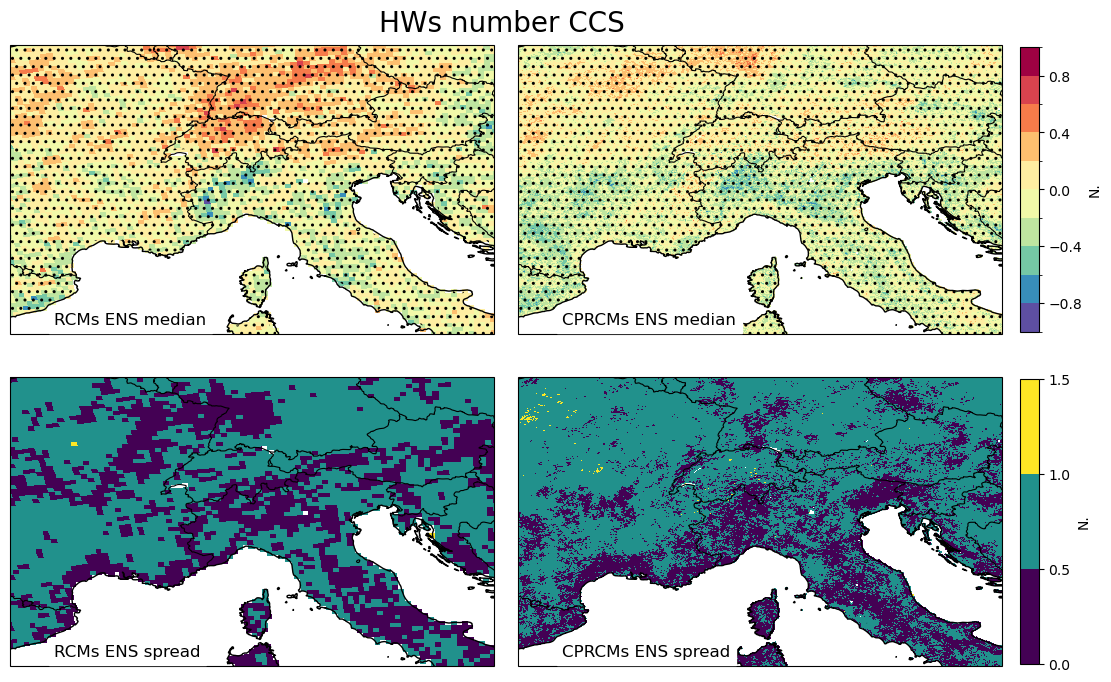

In [36]:
if D == 'ccs' : 
    
    # Create a colormap with your custom levels
    cmap = plt.get_cmap(colormap_ccs[W], len(levels_ccs) - 1) #'YlOrRd'
    cmap_std = plt.get_cmap(colormap_std,len(levels_std) - 1)
    # Create a BoundaryNorm for discrete levels
    norm = mcolors.BoundaryNorm(levels_ccs, cmap.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
        
    
    # Set the value for which you want to apply hatching
    hatch_value = 9999
    
    
    P1 = axes[0,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    

    P2 = axes[0,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    
    
    P3 = axes[1,0].pcolormesh(
            V_rcm_std.lon,
            V_rcm_std.lat,
            V_rcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    

    P4 = axes[1,1].pcolormesh(
            V_cprcm_std.lon,
            V_cprcm_std.lat,
            V_cprcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    
   

    axes[0,0].contourf(            
        V_rcm.lon,
        V_rcm.lat,
        to_stipple_rcm,
        hatches=['..'],
        alpha=0.0,
        transform=ccrs.PlateCarree())   
    
    
    axes[0,1].contourf(            
        V_cprcm.lon,
        V_cprcm.lat,
        to_stipple_cprcm,
        hatches=['..'],
        alpha=0.0,
        transform=ccrs.PlateCarree()) 
    
    
    axes[0,0].coastlines(linewidth = 1)
    axes[0,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,0].set_facecolor('white')
    axes[0,0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[0,1].coastlines(linewidth = 1)
    axes[0,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,1].set_facecolor('white')
    axes[0,1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    

    axes[1,0].coastlines(linewidth = 1)
    axes[1,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,0].set_facecolor('white')
    axes[1,0].text(2.45,40.8,'RCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1,1].coastlines(linewidth = 1)
    axes[1,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,1].set_facecolor('white')
    axes[1,1].text(2.45,40.8,'CPRCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0,0],axes[0,1]), orientation='vertical',label=clabs[W],aspect=15,shrink=.90,pad=.015)#extend
    
    #cb = fig.colorbar(P1, ax=(axes[0,0]), orientation='vertical',label=clabs[W],aspect=15,shrink=.90,pad=.015,extend='both')#extend
    #cb = fig.colorbar(P2, ax=(axes[0,1]), orientation='vertical',label=clabs[W],aspect=15,shrink=.90,pad=.015,extend='both')#extend
    
    cb = fig.colorbar(P4, ax=(axes[1,0],axes[1,1]), orientation='vertical',label=clabs[W],aspect=15,shrink=.90,pad=.015)

    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.95, f'{var_to_tit} CCS', fontsize=20, ha='center')
  
    plt.savefig(f'./ensembles_{do_plot}_{var}_ttest_derived_on_rcp85_clima.png',dpi=300)  
    plt.show()